# UNFILTERED 
# Deduplicating Text in Common-Crawl for LLM Training. 

In this notebook, we will cover how to perform the minhash deduplication algorithm on html documents from the common crawl dataset.

The Common Crawl corpus contains petabytes of data, with its oldest entries dating back to 2008, including raw web page data, metadata extracts, and text extracts.

LLMs require massive amounts of data to train on. Early foundation models like GPT-3 and T5 saw improvements in model performance due to deduplication efforts. Deduplication makes it far less likely that the model regurgitates memorized text leading to better responses.

*See [Deduplicating Training Data Makes Language Models Better (Lee et. all)](https://aclanthology.org/2022.acl-long.577.pdf)*

---

## The MinHash Deduplication algorithm

If you google "minhash deduplication" you'll find a variety of sources that can walk you through the aglorithm. [Finding Near Duplicates with Jaccard Similarity and MinHash by Nelson Elhage](https://blog.nelhage.com/post/fuzzy-dedup/) is a great place to start, but if you are looking for the canonical reference for the MinHash deduplication algorithm, it originates from the seminal paper by Andrei Z. Broder, published in 1997, titled:

```text
"On the resemblance and containment of documents"
Published in: Proceedings of the Compression and Complexity of Sequences 1997 (SEQUENCES '97)
Publisher: IEEE Computer Society
DOI: 10.1109/SEQUEN.1997.666900
```

A video walkthough of the algorithm is also available through [Mike Mull's presentation on YouTube](https://www.youtube.com/watch?v=KKNPmvELUP4). He even provides a [jupyter notebook](https://github.com/papers-we-love/san-diego/blob/master/presentations/2016-11-03-resemblance-containment-documents/Broder97.ipynb) detailing the core primatives and how they are calculated in pure python. 

In this notebook, we will adopt a more practical approach, leveraging daft primatives and small user-defined-functions to accelerate development and process documents at scale. 


### First we will need to authenticate with AWS to access S3

Crawl data is free to access by anyone from anywhere. The data is hosted by Amazon Web Services’ Open Data Sets Sponsorships program on the bucket s3://commoncrawl/, located in the US-East-1 (Northern Virginia) AWS Region. The most performative means of accessing Common crawl is through s3, so you'll need to authenticate with an `AWS_ACCESS_KEY_ID` and `AWS_SECRET_ACCESS_KEY`. 

Common Crawl data can also be accessed without authentication, anonymously via it's http endpoint, but for the purposes of this walkthrough we are going to stick with S3. 


In [51]:
import daft
from daft.io import IOConfig, S3Config
import os
from dotenv import load_dotenv

# Make sure to define your AWS_ACCESS_KEY_ID and AWS_SECRET_ACCESS_KEY in your environment variables or in a .env file
load_dotenv()

s3_config = S3Config(
    region_name="us-east-1",
    requester_pays=True,
    key_id=os.environ["AWS_ACCESS_KEY_ID"],
    access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
    anonymous=False,
)

IO_CONFIG = IOConfig(s3=s3_config)
daft.set_planning_config(default_io_config=IO_CONFIG)

DaftContext(_ctx=<builtins.PyDaftContext object at 0x10836d270>)

## Loading Common Crawl Documents 

We will be accessing Common Crawl through [WARC files](https://commoncrawl.org/blog/navigating-the-warc-file-format) since daft supports the format natively with `daft.read_warc(uri)`

In [52]:
NUM_ROWS = 1000 # We'll limit this demo to a small number of rows for our initial walkthrough

In [ ]:
df_warc = daft.read_warc("s3://commoncrawl/crawl-data/CC-MAIN-2018-17/segments/*/warc/*.warc.gz").limit(NUM_ROWS)
df_warc.show(3) # Inspect the first 3 rows

WARC-Record-IDUtf8,WARC-TypeUtf8,"WARC-DateTimestamp(Nanoseconds, Some(""Etc/UTC""))",Content-LengthInt64,WARC-Identified-Payload-TypeUtf8,warc_contentBinary,warc_headersUtf8
32db05be-869c-4acb-be66-731d1ee3327a,warcinfo,2018-04-23 14:49:33 UTC,327,None,"b""robots: classic\r\nhostname: ip-10""...","{""Content-Type"":""application/warc-fields"",""WARC-Filename"":""CC-MAIN-20180423144933-20180423164933-00000.warc.gz""}"
a7c4056d-fafe-4ee7-b5b6-0398e12c1cad,request,2018-04-23 15:26:53 UTC,312,None,"b""GET /index.phtml?PUT=A_SORT&CHANNE""...","{""Content-Type"":""application/http; msgtype=request"",""WARC-IP-Address"":""220.228.7.79"",""WARC-Target-URI"":""http://007sex.t244.com/index.phtml?PUT=A_SORT&CHANNEL=R52&SORT=HOT&FID=1142610"",""WARC-Warcinfo-ID"":""<urn:uuid:32db05be-869c-4acb-be66-731d1ee3327a>""}"
8445cb93-cead-409d-9a2b-39daded71824,response,2018-04-23 15:26:53 UTC,234179,text/html,"b""HTTP/1.1 200 OK\r\nServer: Apache/""...","{""Content-Type"":""application/http; msgtype=response"",""WARC-Block-Digest"":""sha1:TYXDWXTGYEUIARQUFGUX6767ATZFH6AW"",""WARC-Concurrent-To"":""<urn:uuid:a7c4056d-fafe-4ee7-b5b6-0398e12c1cad>"",""WARC-IP-Address"":""220.228.7.79"",""WARC-Payload-Digest"":""sha1:SRD4PXH4NV4IHAC4WLUGES2EBNHA2OHH"",""WARC-Target-URI"":""http://007sex.t244.com/index.phtml?PUT=A_SORT&CHANNEL=R52&SORT=HOT&FID=1142610"",""WARC-Warcinfo-ID"":""<urn:uuid:32db05be-869c-4acb-be66-731d1ee3327a>""}"


In [ ]:
# Lets investigate the different types of payloads we have: 
df_warc.select("WARC-Identified-Payload-Type").distinct().show()

### Step 1: Preprocessing
Since we are primarily concerned with text, we will focus on text/html payloads, extracting text content from html body and normalizing the text itself


In [54]:
from daft import col
from daft.functions import monotonically_increasing_id


# Define a UDF to remove http headers from the payload
@daft.func()
def remove_http_headers(x: str) -> str:
    if x is None:
        return ""
    if len(x.split("\r\n\r\n")) > 1:
        return x.split("\r\n\r\n")[1]
    return ""

# Filter the dataframe to only include text/html payloads
df_html = df_warc.where(col("WARC-Identified-Payload-Type")== "text/html")

# Seperate the http headers from the payloads
df_html = (
    df_html
    .with_column("content_raw", remove_http_headers(col("warc_content").try_decode("utf-8")))
    .where(col("content_raw") != "")
)   

# Simplify the dataframe to just the content and add a monotonically increasing int id
df_html = (
    df_html
    .with_columns_renamed({"WARC-Identified-Payload-Type": "content_type",})
    .with_column("id", monotonically_increasing_id())
    .select("WARC-Record-ID", "id", "content_type", "content_raw")
)

df_html.show(3)

### Extracting Text from HTML body

In [55]:
from selectolax.parser import HTMLParser
import re
import hashlib

# Define a UDF to extract text from HTML content, Specifically (article, main, p, h1, h2, h3, li)
@daft.func()
def extract_blocks(html: str) -> list[str]:
    tree = HTMLParser(html)
    for n in tree.css("script,style,noscript"):  n.decompose()
    blocks = []
    for node in tree.css("article, main, p, h1, h2, h3, li"):
        txt = node.text(separator=" ", strip=True)
        if not txt: 
            continue
        blocks.append(txt)
    return blocks

df_text = df_html.with_column("content_text", extract_blocks(col("content_raw")).list.join(" "))
df_text.show(3)

# Minhash

Now that we have extracted the text out of the html we move to normalize the inputs and calculate our minhash vectors using daft's `minhash` expression! No need to build shingles!

In [56]:
K = 64 # Number of Permutations
SEED = 43 # Seed for the hash function
NGRAM_SIZE = 5 # Size of the n-grams
index_col = "id" 
content_col = "content_text"


In [57]:
# Normalize text 
df_norm = df_text.with_column("content_normalized", 
    col(content_col).str.normalize(
        remove_punct=True, 
        lowercase=True, 
        nfd_unicode=True, 
        white_space=True
    ) 
)
df_norm.show(3)


In [58]:
# Calculate the minhash vectors
df_minhash = (
    df_norm
    .with_column("min_hashes", col("content_normalized").minhash(
        num_hashes = K,
        ngram_size = NGRAM_SIZE,
        seed = SEED, 
        hash_function = 'xxhash'
        )
    )
)
df_minhash.show(3)

### Band Generation and Bucketing

Next, we will:
1. Use the optimal_param function to determine the best band (b) and row (r) parameters for our LSH bucketing
2. Split each document's minhash vector into b bands of r rows each
3. Create buckets by hashing each band's signature, grouping similar documents together


In [59]:
from scipy.integrate import quad as integrate

def optimal_param(
    threshold: float,
    num_perm: int,
    false_positive_weight: float = 0.5,
    false_negative_weight: float = 0.5,
):
    """
    Compute the optimal `MinHashLSH` parameter that minimizes the weighted sum
    of probabilities of false positive and false negative, taken from datasketch.

    Parameters
    ----------
    threshold : float
        The threshold for similarity.
    num_perm : int
        The number of permutations.
    false_positive_weight : float
        The weight of false positive.
    false_negative_weight : float
        The weight of false negative.

    Returns
    -------
    Tuple[int, int]
        The optimal `b` and `r` parameters.
        The number of bands, and the number of rows per band respectively.

    Examples
    --------
    >>> optimal_param(0.7, 256)
    (25, 10)
    """

    def false_positive_area(threshold: float, b: int, r: int):
        """Source: `datasketch.lsh`"""

        def area(s):
            return 1 - (1 - s ** float(r)) ** float(b)

        a, _ = integrate(area, 0.0, threshold)
        return a

    def false_negative_area(threshold: float, b: int, r: int):
        """Source: `datasketch.lsh`"""

        def area(s):
            return 1 - (1 - (1 - s ** float(r)) ** float(b))

        a, _ = integrate(area, threshold, 1.0)
        return a

    min_error = float("inf")
    opt = (0, 0)
    for b in range(1, num_perm + 1):
        max_r = int(num_perm / b)
        for r in range(1, max_r + 1):
            fp = false_positive_area(threshold, b, r)
            fn = false_negative_area(threshold, b, r)
            error = fp * false_positive_weight + fn * false_negative_weight
            if error < min_error:
                min_error = error
                opt = (b, r)
    return opt

In [60]:
# Choose B bands and R rows per band such that B · R = num_perm.
B, R = optimal_param(0.717, K)

In [61]:
from daft import lit

# Band Generation
df_bands = (
    df_minhash
    .with_column("bands", col("min_hashes").list.chunk(R))
    .with_column("band_idx", lit(list(range(B))))
    .explode("bands", "band_idx")
    .select(index_col, "band_idx", "bands")
)
df_bands.show(20)    

idUInt64,band_idxInt64,bandsFixedSizeList[UInt32; 8]
0,0,"[3697088, 1518022, 158296217, 81165076, 201524291, 105162463, 2415564, 221271637]"
0,1,"[309290987, 215957746, 85418473, 219164272, 235977309, 88582346, 520879039, 208497800]"
0,2,"[433470347, 33660272, 13272191, 892349, 160706706, 575773313, 17223375, 486725966]"
0,3,"[309775548, 50387970, 178674135, 119019392, 253462977, 160536982, 1212652710, 152966654]"
0,4,"[111897494, 237675758, 198425003, 330912790, 220042701, 30112684, 35409885, 1730166]"
...,...,...
1,7,"[5156078, 6014555, 2021784, 2202498, 1723151, 6193692, 2086801, 12640369]"
2,0,"[4294967295, 4294967295, 4294967295, 4294967295, 4294967295, 4294967295, 4294967295, 4294967295]"
2,1,"[4294967295, 4294967295, 4294967295, 4294967295, 4294967295, 4294967295, 4294967295, 4294967295]"
2,2,"[4294967295, 4294967295, 4294967295, 4294967295, 4294967295, 4294967295, 4294967295, 4294967295]"


In [62]:
# Grouping Bands
df_grouped = (
    df_bands
    .groupby(col("band_idx"), col("bands"))
    .agg(col(index_col).agg_list().alias("nodes"))
)
df_grouped.show()

band_idxInt64,bandsFixedSizeList[UInt32; 8],nodesList[UInt64]
4,"[228220132, 108821086, 89490923, 102852926, 80847868, 8327964, 7394733, 68735746]",[65]
2,"[3065857, 1870859, 1733607, 1080429, 1829090, 3332600, 4283967, 430838]",[86]
3,"[5452039, 22318439, 5024127, 1730472, 11662891, 27787358, 3218751, 12031225]",[27]
4,"[949192949, 2240981022, 3720915435, 4021760533, 3593099149, 818457772, 2175013294, 2340877510]",[3]
5,"[4294967295, 4294967295, 4294967295, 4294967295, 4294967295, 4294967295, 4294967295, 4294967295]","[5, 6, 10, 12, 17, 21, 22, 31, 32, 34, 35, 38, 40, 47, 48, 49, 50, 51, 54, 62, 63, 67, 68, 70, 74, 77, 79, 82, 85, 93, 94, 102, 112, 113, 115, 116, 119, 120, 121, 122, 123, 127, 128]"
7,"[70161027, 26660943, 12935704, 797038, 18387415, 75495652, 18452033, 2879151]",[8]
5,"[65403182, 266017616, 24613051, 40888313, 29120082, 186495138, 162965028, 6409214]",[55]
6,"[327097, 28945, 308474, 1896096, 1668755, 362904, 257971, 1293480]",[76]


## Connected Components
Every band whose `nodes` have more than one entry are now candidates for consideration. 
Next we are going to leverage a few tricks from graph theory to 

In [63]:
# Generate Graph Edges
df_edges = (
    df_grouped
    .with_column("left_edge", col("nodes").list.min())
    .explode("nodes")
    .select("left_edge", right_edge=col("nodes"))
    .filter(col("left_edge") != col("right_edge"))
    .distinct()
)
df_edges.show()

left_edgeUInt64,right_edgeUInt64
31,32
31,33
0,68
0,17
0,101
0,49
0,111
0,39


In [70]:
# prep edges for connected components
df_edges_clean = (
    df_edges.select(col("left_edge").alias("u"), col("right_edge").alias("v"))
    .where(~col("u").is_null())
    .where(~col("v").is_null())
    .where(col("u") != col("v"))
    .select(col("u").cast(daft.DataType.int64()), col("v").cast(daft.DataType.int64()))
)


In [72]:
import networkx as nx

df_pd_edges = df_edges_clean.to_pandas()


nx_graph = nx.from_pandas_edgelist(df_pd_edges, source="u", target="v")
nx_components = [frozenset(c) for c in nx.connected_components(nx_graph)]

print(nx_components)

[frozenset({6, 14, 15, 16, 20, 21, 28, 29, 30, 41, 42, 43, 44, 47, 52, 53, 59, 60, 61, 67, 68, 69, 70, 71, 72, 75, 78, 79, 84, 85, 86, 88, 90, 94, 95, 96, 99, 100}), frozenset({76, 77}), frozenset({8, 9})]


/Users/everett-founder/git/ugh/daft-minhash-dedupe/.venv/lib/python3.11/site-packages/daft/dashboard/__init__.py:91: UserWarning: Failed to broadcast metrics over http://127.0.0.1:3238/api/queries: HTTP Error 400: Bad Request
  warnings.warn(f"Failed to broadcast metrics over {url}: {e}")


ok nx says we get 
```text
[frozenset({6, 14, 15, 16, 20, 21, 28, 29, 30, 41, 42, 43, 44, 47, 52, 53, 59, 60, 61, 67, 68, 69, 70, 71, 72, 75, 78, 79, 84, 85, 86, 88, 90, 94, 95, 96, 99, 100}), frozenset({76, 77}), frozenset({8, 9})]

```

In [86]:
# Now with igraph 
import igraph as ig

# Create igraph graph from edges
g = ig.Graph.DataFrame(df_pd_edges, directed=False)

# Get connected components using igraph
strong_components = g.connected_components(mode="strong")
weak_components = g.connected_components(mode="weak")

In [87]:
print(strong_components)
print(weak_components)


Clustering with 101 elements and 62 clusters
[ 0] 0
[ 1] 1
[ 2] 2
[ 3] 3
[ 4] 4
[ 5] 5
[ 6] 6, 14, 15, 16, 20, 21, 28, 29, 30, 41, 42, 43, 44, 47, 52, 53, 59, 60,
     61, 67, 68, 69, 70, 71, 72, 75, 78, 79, 84, 85, 86, 88, 90, 94, 95, 96,
     99, 100
[ 7] 7
[ 8] 8, 9
[ 9] 10
[10] 11
[11] 12
[12] 13
[13] 17
[14] 18
[15] 19
[16] 22
[17] 23
[18] 24
[19] 25
[20] 26
[21] 27
[22] 31
[23] 32
[24] 33
[25] 34
[26] 35
[27] 36
[28] 37
[29] 38
[30] 39
[31] 40
[32] 45
[33] 46
[34] 48
[35] 49
[36] 50
[37] 51
[38] 54
[39] 55
[40] 56
[41] 57
[42] 58
[43] 62
[44] 63
[45] 64
[46] 65
[47] 66
[48] 73
[49] 74
[50] 76, 77
[51] 80
[52] 81
[53] 82
[54] 83
[55] 87
[56] 89
[57] 91
[58] 92
[59] 93
[60] 97
[61] 98
Clustering with 101 elements and 62 clusters
[ 0] 0
[ 1] 1
[ 2] 2
[ 3] 3
[ 4] 4
[ 5] 5
[ 6] 6, 14, 15, 16, 20, 21, 28, 29, 30, 41, 42, 43, 44, 47, 52, 53, 59, 60,
     61, 67, 68, 69, 70, 71, 72, 75, 78, 79, 84, 85, 86, 88, 90, 94, 95, 96,
     99, 100
[ 7] 7
[ 8] 8, 9
[ 9] 10
[10] 11
[11] 12
[12] 13


In [ ]:
strong_components = [c for c in strong_components if len(c) > 1]
print(strong_components)
weak_components = [c for c in weak_components if len(c) > 1]
print(weak_components)

# Ok so for 1000 documents we get the same connected components (weak vs strong) with both igraph and networkx


[[6, 14, 15, 16, 20, 21, 28, 29, 30, 41, 42, 43, 44, 47, 52, 53, 59, 60, 61, 67, 68, 69, 70, 71, 72, 75, 78, 79, 84, 85, 86, 88, 90, 94, 95, 96, 99, 100], [8, 9], [76, 77]]
[[6, 14, 15, 16, 20, 21, 28, 29, 30, 41, 42, 43, 44, 47, 52, 53, 59, 60, 61, 67, 68, 69, 70, 71, 72, 75, 78, 79, 84, 85, 86, 88, 90, 94, 95, 96, 99, 100], [8, 9], [76, 77]]


# HOLY S#!T THAT WAS 20 times faster with igraph... 10.2s vs 0.6

Why don't we just udf igraph here? Hold that thought, igraph lets us plot this 

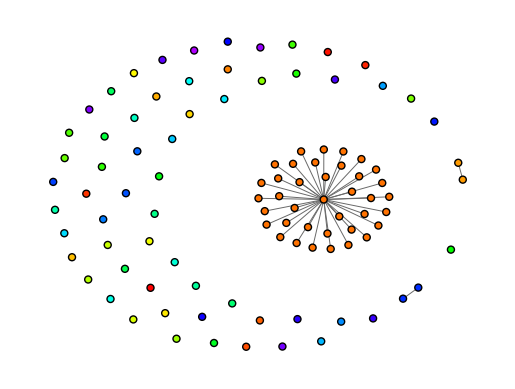

In [79]:
import matplotlib.pyplot as plt
import random

fig, ax = plt.subplots()
ig.plot(
    components,
    target=ax,
    palette=ig.RainbowPalette(),
    vertex_size=7,
    vertex_color=list(map(int, ig.rescale(components.membership, (0, 200), clamp=True))),
    edge_width=0.7
)
plt.show()

# GAH so cool. 
Ok lets UDF this. 

... wait... if we udf it, we wont get the full list. we would have to serialize the entire edgelist to pandas... 

whatever we can parallelize this if we have to. 

In [ ]:
@daft.udf(return_dtype=daft.DataType.list(daft.DataType.int64()))
def ig_connected_components(u: daft.Series, v: daft.Series):
    # Assume we are getting the clean edges 
    df_pd_edges = df_edges_clean.to_pandas()
    return components(edges)

df_components = df_edges_clean.with_column("components", connected_components(df_edges_clean))
df_components.show()


What we have: An undirected graph where each row is an edge left_edge -> right_edge meaning two documents likely match (they co-occurred in at least one band).

What we want: Assign a single representative ID per connected cluster of documents, so we can keep one per cluster (e.g., the minimum ID).

### Star Contraction
Now we will iteratively compress the graph using two alternating phases until convergence:
- Large-star: Every node points to the minimum ID in its neighborhood (including itself). This quickly pulls nodes toward low-ID “hubs.”
- Small-star: Re-orient edges to ensure u < v (canonicalize) and repeat contraction, which merges local hubs together.
- Repeat large-star then small-star until nothing changes. The “parent” each node ends up pointing to is its component representative.

### 1. Canonicalize edges to undirected form
Ensure we treat the graph as undirected by unioning (u,v) with (v,u).

In [14]:
from daft import Expression, struct, DataFrame

def ee(u: Expression, v: Expression):
    return struct(u.alias("u"), v.alias("v")) 

### 2. Large-star phase
- Group neighbors by u.
- Compute min_neighbor = min(neighbors).
- Use min(u, min_neighbor) as the node’s “parent.”
- Emit edges (u, parent) but only where parent > u to avoid self-loops and duplicates.

In [89]:
b = (
    df_edges.select(col("left_edge").alias("u"), col("right_edge").alias("v"))
    .where(~col("u").is_null())
    .where(~col("v").is_null())
    .where(col("u") != col("v"))
    .collect() # Materialize
)
b.show(10)

uUInt64,vUInt64
6,53
6,72
6,95
6,100
6,20
6,28
6,71
6,43
76,77
6,59


In [ ]:
l_star_1 = (
    b
    # large_star_map
    .select("u", "v") # Grab the edges 
    .union_all(b.select(col("v").alias("u"), col("u").alias("v"))) # Include upper and lower triangles

    .groupby("u").agg_list("v") # Group by u and aggregate the list of v's 
    # Now we have all relationships between u and v expressed as a list of v's for each u
    # large_star_reduce
    .with_column("min_edge", col("v").list.min()) # Find the minimum v for each u and call it min_edge
    .with_column("min_edge", (col("u") <= col("min_edge")).if_else(col("u"), col("min_edge"))) # If u is less than the min_edge, use u, otherwise use the min_edge... this is just a sanity check to ensure we are always moving towards lower ids. 
)
l_star_1.show(10)

uUInt64,vList[UInt64],min_edgeUInt64
47,[6],6
79,[6],6
9,[8],8
75,[6],6
85,[6],6
86,[6],6
99,[6],6
29,[6],6
60,[6],6
28,[6],6


This looks like our results from igraph and nx

Ok I've been staring at this error for several hours and am thoroughly annoyed. 

What the heck is this doing anyways? I have no idea. 

In [ ]:
# last op of large star fails - debugging
l_star_2 = (
    l_star_1
    .select(col("u").list.map(ee(daft.element(), col("min_edge"))).alias("e"), col("u")) 
) # ok first off col("u") isn't a list... gpt mentioned this already, but might as well see what happens when we try "v"
l_star_2.show(10) 
# Next op is explode on e so e must be a list of structs?

DaftCoreException: DaftError::External Unable to create logical plan node.
Due to: DaftError::ComputeError Input must be a list

In [ ]:
l_star_2_1 = (
    l_star_1 #                        u                 v 
    .select(col("v").list.map(ee(daft.element(), col("min_edge"))).alias("e"), col("u")) 
) # ok first off col("u") isn't a list... gpt mentioned this already, but might as well see what happens when we try "v"
l_star_2_1.show(10) 

                                                           d





































































Error when running pipeline node Project


DaftCoreException: DaftError::ComputeError Mismatch of expected expression name and name from computed series (v vs struct) for expression: list_map(col(1: v), struct(explode(col(1: v)) as u, if [col(0: u) <= col(2: min_edge)] then [col(0: u)] else [col(2: min_edge)] as min_edge as v))

Nope still an error. This is just trying to take the list of elements and turn a new column, e into this list of structs containing the current element and the min edge....

this is building a map of the current element to the min edge... 

we have the min edge.... 

... wait so we are rebuilding the edges?

lets look at the other ops. 


In [ ]:
.explode("e") # exploding the list of structs into a new row for each element in the list where the struct contains the current element and the min edge
.where(col("e")["v"] > col("u")).select("e") # only grab rows where "e"'s min edge is greater than "u" ... why did we have to do this in a struct?
# ok... so "v" is just the min edge which was either "u" or the minimum of the list of v's for each u... so we are filter
.where(~col("e").is_null()) # filter out any nulls (WHAT? I THOUGHT WE FILTERED OUT NULLS EARLIER?)
.distinct() # remove duplicates
.select(col("e")["*"]) # select the struct
.where(col("u") != col("v")) # filter out any rows where the current element is equal to the min edge
.collect() # Materialize

What if we do something similar and try to achieve the same result tacking on new columns instead of this more complex data structure. 

In [94]:
#reminder of l_star_1
l_star_1.show(10)
# ok so we are trying to do the same thing but with new columns. 
# so we want to take each v and make a new column called min_edge which is the minimum of the list of v's for each u. 
# and then we want to filter out any rows where the current element is equal to the min edge. 
# and then we want to collect the results. 


uUInt64,vList[UInt64],min_edgeUInt64
76,[77],76
59,[6],6
96,[6],6
47,[6],6
79,[6],6
9,[8],8
75,[6],6
85,[6],6
86,[6],6
77,[76],76


In [96]:
l_star_2_new = (
    l_star_1 
    .with_column("v", col("v").explode())
    .where(col("v") > col("u"))
    .where(~col("v").is_null()) #should be a no-op but just in case
    .distinct()
    .select(col("u"), col("v"))
)
l_star_2_new.show(10) 

uUInt64,vUInt64
6,94
8,9
6,52
6,61
6,96
6,59
6,14
6,90
6,41
6,95


In [ ]:
# lets see what we get if we group by u and agg the list of v's again 
l_star_2_new_2 = (
    l_star_2_new
    .groupby("u").agg_list("v")
)
l_star_2_new_2.show(10)




uUInt64,vList[UInt64]
6,"[69, 68, 99, 43, 28, 79, 88, 21, 30, 20, 60, 41, 95, 100, 42, 78, 84, 72, 44, 75, 16, 67, 47, 71, 59, 14, 90, 70, 85, 53, 29, 15, 86, 94, 52, 61, 96]"
76,[77]
8,[9]


umm... that looks a hell of a lot like our answer... 

In [106]:
# pull u and v into a list of lists and compare that to our igraph output. 
# ... hmmm how I just add element of u to the list of v's as a new column? 
# is there an append method? I didnt see one. Whatever, I'll just pylist now. 
daft_components_pylist = l_star_2_new_2.to_pylist()
print(daft_components_pylist)


[{'u': 6, 'v': [69, 68, 99, 60, 59, 14, 90, 43, 28, 79, 88, 21, 30, 20, 44, 75, 16, 67, 47, 71, 94, 52, 61, 96, 41, 95, 100, 42, 78, 84, 72, 70, 85, 53, 29, 15, 86]}, {'u': 76, 'v': [77]}, {'u': 8, 'v': [9]}]


/Users/everett-founder/git/ugh/daft-minhash-dedupe/.venv/lib/python3.11/site-packages/daft/dashboard/__init__.py:91: UserWarning: Failed to broadcast metrics over http://127.0.0.1:3238/api/queries: HTTP Error 400: Bad Request
  warnings.warn(f"Failed to broadcast metrics over {url}: {e}")


In [111]:
daft_components = [[d["u"],*d["v"]] for d in daft_components_pylist]
print(daft_components)
dc_sorted = [sorted(c) for c in daft_components]
print(dc_sorted)
print(strong_components)

[[6, 69, 68, 99, 60, 59, 14, 90, 43, 28, 79, 88, 21, 30, 20, 44, 75, 16, 67, 47, 71, 94, 52, 61, 96, 41, 95, 100, 42, 78, 84, 72, 70, 85, 53, 29, 15, 86], [76, 77], [8, 9]]
[[6, 14, 15, 16, 20, 21, 28, 29, 30, 41, 42, 43, 44, 47, 52, 53, 59, 60, 61, 67, 68, 69, 70, 71, 72, 75, 78, 79, 84, 85, 86, 88, 90, 94, 95, 96, 99, 100], [76, 77], [8, 9]]
[[6, 14, 15, 16, 20, 21, 28, 29, 30, 41, 42, 43, 44, 47, 52, 53, 59, 60, 61, 67, 68, 69, 70, 71, 72, 75, 78, 79, 84, 85, 86, 88, 90, 94, 95, 96, 99, 100], [8, 9], [76, 77]]


In [113]:
# that looks right to me... 
# How to validate equialence here. 
dc_sorted == strong_components


False

In [117]:
# bruh 
dc_sorted[0] == strong_components[0]

True

In [118]:
dc_sorted[1] == strong_components[2]

True

In [119]:
dc_sorted[2] == strong_components[1]

True

In [122]:
# Ugh how do you do this automatically with sets? 

{frozenset(c) for c in strong_components} == {frozenset(c) for c in daft_components} # LFG

True

welp..... I guess I did something right. What was the full op again? 

In [ ]:
b = (
    df_edges.select(col("left_edge").alias("u"), col("right_edge").alias("v"))
    .where(~col("u").is_null())
    .where(~col("v").is_null())
    .where(col("u") != col("v"))
    .collect() # Materialize
)
# l star
a = (
    b
    # large_star_map
    .select("u", "v") 
    .union_all(b.select(col("v").alias("u"), col("u").alias("v"))) # Include upper and lower triangles

    .groupby("u").agg_list("v") # Group by u and aggregate the list of v's 

    .with_column("min_edge", col("v").list.min()) # Find the minimum v for each u and call it min_edge
    .with_column("min_edge", (col("u") <= col("min_edge")).if_else(col("u"), col("min_edge"))) # If u is less than the min_edge, use u, otherwise use the min_edge... this is just a sanity check to ensure we are always moving towards lower ids. 
    .with_column("v", col("v").explode())
    .where(col("v") > col("u"))
    .where(~col("v").is_null()) #should be a no-op but just in case
    .distinct()
    .select(col("u"), col("v"))
)

### 3. Small-star phase
- Re-orient all edges so u < v (canonical).
- Group neighbors by u, compute min_neighbor, connect (u, parent) like above.
- This step merges local minima across previously separate stars.

In [ ]:
def small_star_phase(df: DataFrame):
    return (
        df
        # small_star_map
        .select((col("u") > col("v")).if_else(ee(col("u"), col("v")), ee(col("v"), col("u"))).alias("e"))
        .select(col("e")["*"])

        .groupby("u").agg_list("v")
        # small_star_reduce
        .with_column("min_edge", col("v").list.min())
        .with_column("min_edge", (col("u") <= col("min_edge")).if_else(col("u"), col("min_edge")))
        .select(col("u").list.map(ee(daft.element(), col("min_edge"))).alias("e"), col("u"), col("min_edge"))
        # TODO: list_append

        .explode("e")
        .where(~col("e").is_null())
        .distinct()
        .select(col("e")["*"])
        .collect() # Materialize
  )

### 4. Convergence check
- Compare a stable summary of edges before/after (hash sum is fine).
- If stable, stop; otherwise repeat.

In [ ]:
def check_convergence(a: DataFrame, b: DataFrame):
    a_hash = a.select(col("u").hash().alias("hash")).sum("hash").to_pydict()["hash"][0]
    b_hash = b.select(col("u").hash().alias("hash")).sum("hash").to_pydict()["hash"][0]
    if a_hash == b_hash:
        return True

### Combining Stages

In [21]:
def connected_components(
    edges: DataFrame,     
    left_id_col="left_edge",
    right_id_col="right_edge",
    output_index_col=index_col,
    output_component_col="__component__",
):
    # Convert column names to u, v
    b = (
        edges.select(col(left_id_col).alias("u"), col(right_id_col).alias("v"))
        .where(~col("u").is_null())
        .where(~col("v").is_null())
        .collect()
    )    
    while True:
        a = large_star_phase(b)
        b = small_star_phase(a)
        if check_convergence(a, b):
            break
    
    # Revert column names and return contracted star edges
    return (
        b
        .select(col("u").alias(output_index_col), col("v").alias(output_component_col))
        .collect()
    )
    

In [23]:

def components(
    df: DataFrame,
    left_id_col: str = "u",
    right_id_col: str = "v",
    output_index_col: str = "u",
    output_component_col: str = "component"
) -> DataFrame:
    b = (
        df.select(col(left_id_col).alias("u"), col(right_id_col).alias("v"))
        .where(~col("u").is_null())
        .where(~col("v").is_null())
        .collect()
    )    
    while True:
        a = (b
             # large_star_map
             .select("u", "v")
             .union_all(b.select(col("v").alias("u"), col("u").alias("v")))

             .groupby("u").agg_list("v")
             # large_star_reduce
             .with_column("min_edge", col("v").list.min())
             .with_column("min_edge", (col("u") <= col("min_edge")).if_else(col("u"), col("min_edge")))
             .select(col("u").list.map(ee(daft.element(), col("min_edge"))).alias("e"), col("u"))

             .explode("e")
             .where(col("e")["v"] > col("u")).select("e")
             .where(~col("e").is_null())
             .distinct()
             .select(col("e")["*"])
             .where(col("u") != col("v"))
             .collect()
        )
        b = (a
             # small_star_map
             .select((col("u") > col("v")).if_else(ee(col("u"), col("v")), ee(col("v"), col("u"))).alias("e"))
             .select(col("e")["*"])

             .groupby("u").agg_list("v")
             # small_star_reduce
             .with_column("min_edge", col("v").list.min())
             .with_column("min_edge", (col("u") <= col("min_edge")).if_else(col("u"), col("min_edge")))
             .select(col("u").list.map(ee(daft.element(), col("min_edge"))).alias("e"), col("u"), col("min_edge"))
             # TODO: list_append

             .explode("e")
             .where(~col("e").is_null())
             .distinct()
             .select(col("e")["*"])
             .collect()
        )
        # check convergence
        a_hash = a.select(col("u").hash().alias("hash")).sum("hash").to_pydict()["hash"][0]
        b_hash = b.select(col("u").hash().alias("hash")).sum("hash").to_pydict()["hash"][0]
        if a_hash == b_hash:
            return (
                b
                .select(col("u").alias(output_index_col), col("v").alias(output_component_col))
                .collect()
            )

In [25]:
assignment = components(
    df_edges,
    left_id_col="left_edge",
    right_id_col="right_edge",
    output_index_col=index_col,
    output_component_col="__component__",
)


/Users/everett-founder/git/ugh/daft-minhash-dedupe/.venv/lib/python3.11/site-packages/daft/dashboard/__init__.py:91: UserWarning: Failed to broadcast metrics over http://127.0.0.1:3240/api/queries: HTTP Error 400: Bad Request
  warnings.warn(f"Failed to broadcast metrics over {url}: {e}")




🗡️ 🐟 Warc Scan: 00:00 64 rows emitted, 0 B bytes read










🗡️ 🐟 Warc Scan: 00:00 64 rows emitted, 0 B bytes read





🗡️ 🐟 Warc Scan: 00:00 64 rows emitted, 0 B bytes read










































































































🗡️ 🐟 Warc Scan: 00:00 128 rows emitted, 0 B bytes read






















































































































































































































































































































DaftCoreException: DaftError::External Unable to create logical plan node.
Due to: DaftError::ComputeError Input must be a list

In [24]:
# Running the Star Contraction
df_star_edges = connected_components(
    edges=df_edges,
    left_id_col="left_edge",
    right_id_col="right_edge",
    output_index_col=index_col,
    output_component_col="__component__",
)
df_star_edges.show(3)


/Users/everett-founder/git/ugh/daft-minhash-dedupe/.venv/lib/python3.11/site-packages/daft/dashboard/__init__.py:91: UserWarning: Failed to broadcast metrics over http://127.0.0.1:3240/api/queries: HTTP Error 400: Bad Request
  warnings.warn(f"Failed to broadcast metrics over {url}: {e}")


🗡️ 🐟 Warc Scan: 00:00 64 rows emitted, 0 B bytes read



































🗡️ 🐟 Warc Scan: 00:00 128 rows emitted, 0 B bytes read
































































































































































































































































































































































































AttributeError: 'int' object has no attribute 'select'

### 5. Final assignment
- Treat the final v for each u as the component representative.
- Join back to your documents and keep the representative per component.

In [ ]:
# Keep one per component (the representative equals the index)
 (
    df
    .join(assignment.select(col(index_col), col("__component__")), on=index_col, how="left")
    .filter(col("__component__").is_null() | (col("__component__") == col(index_col)))
    .exclude("__component__")
)